# Исследование объявлений о продаже квартир


[Шаг 1. Изучение общей информации](#Шаг-1.-Изучение-общей-информации)

[Шаг 2. Предобработка данных](#Шаг-2.-Предобработка-данных)

[Шаг 3. Расчёт дополнительных параметров](#Шаг-3.-Расчёт-дополнительных-параметров)

[Шаг 4. Исследовательский анализ данных](#Шаг-4.-Исследовательский-анализ-данных)

[Шаг 5. Общий вывод](#Шаг-5.-Общий-вывод)

## Шаг 1. Изучение общей информации

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') # С помощью параметра sep задаем разделитель колонок
print(data)
print(data.info())

#print('==============================')

def info(data): #Функция пробегает по признакам датафрейма и если тип у признака object, то смотрит уникальные значения, в противном случае оценивается распределение

    for column in data.columns:
    
        if data[column].dtype == 'object':
            
            print(column)
            print(data[column].unique())
            print()
            print(data[column].describe())
            print()
            
        else:
            
            print(column)
            
            import plotly.express as px
            print(data[column].describe())
            fig = px.histogram(data, x = column, marginal = 'box', title = 'Распределение '+ column)
            fig.show()
            
#info(data)

       total_images  last_price  total_area first_day_exposition  rooms  \
0                20  13000000.0      108.00  2019-03-07T00:00:00      3   
1                 7   3350000.0       40.40  2018-12-04T00:00:00      1   
2                10   5196000.0       56.00  2015-08-20T00:00:00      2   
3                 0  64900000.0      159.00  2015-07-24T00:00:00      3   
4                 2  10000000.0      100.00  2018-06-19T00:00:00      2   
...             ...         ...         ...                  ...    ...   
23694             9   9700000.0      133.81  2017-03-21T00:00:00      3   
23695            14   3100000.0       59.00  2018-01-15T00:00:00      3   
23696            18   2500000.0       56.70  2018-02-11T00:00:00      2   
23697            13  11475000.0       76.75  2017-03-28T00:00:00      2   
23698             4   1350000.0       32.30  2017-07-21T00:00:00      1   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0                2.70 

### Вывод

Таблица открыта и изучена. Таблица имеет 23699 строк и 22 столбца. Визуальное изучение таблицы показало множество пропущенных значений. Использовали describe() и unique() для категориальных переменных, что позволило нам оценить распределение некоторых признаков и увидеть аномалии.

## Шаг 2. Предобработка данных

### Определение, изучение и заполнение пропущенных значений

In [2]:
print(data['ceiling_height'].value_counts()) # Посчитаем количество значений в столбце 'ceiling_height'
ceiling_height_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median) # Заменяем пустые строки в столбце'ceiling_height' на медианное значение

print('==============================')
def replace_quartile (ceiling_height): # Высота потолков ниже 2 м и выше 4 м выглядит подозрительно, поэтому напишем функцию
    if ceiling_height > 4 or ceiling_height < 2: # которая заменяет подозрительные значения на медианные
        return ceiling_height_median
    return ceiling_height
data['ceiling_height'] = data['ceiling_height'].apply(replace_quartile) # В ячейки заданного столбца записываем значения, возвращаемые функцией при помощи apply()
print(data['ceiling_height'].value_counts())
print('==============================')
data['floors_total'] = data['floors_total'].fillna(0) # Пропущенные значения заменим на 0
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(False) # Пропущенные значения заменим на "False", так как если бы квартира в действительности являлась апартаментами, то её бы отметили как "True"
print(data['is_apartment'].value_counts())
print('==============================')

data['kitchen_area_ratio'] = data['kitchen_area'] / data['total_area'] # Создала столбец, где вычислила соотношение площади кухни к общей площади
kitchen_pivot = data.pivot_table(index = ['rooms'], values = ['kitchen_area_ratio']) # Создала сводную таблицу, чтобы посмотреть как меняется коэффициент соотношения кухни к общей площади в зависимости от числа комнат в квартире

def fill_kitchen(row): # Создала функцию, которая заполняет пропуски в 'kitchen_area' на основании коэффициента соотношения кухни к общей площади в зависимости от числа комнат в квартире
    if pd.notna(row['kitchen_area']): # Если строка не пуста - верни строку
        return row
     
    rooms = row['rooms']   
    if rooms != 0: # Если число комнат не равно нулю
        kitchen_index = kitchen_pivot['kitchen_area_ratio'][rooms] # Возьми значение из таблицы kitchen_pivot значение 'kitchen_area_ratio' и соответствующее ему значение 'rooms'  
        row['kitchen_area'] = kitchen_index * row['total_area'] # Полученное значение kitchen_index умножь на общую площадь квартиры и запиши в df в столбец 'kitchen_area'
        return row
    else: # В случае, когда число комнат равно нулю (свободная планировка, студия)
        row['kitchen_area'] = row['total_area'] - row['living_area'] # заполним пропуски разницей между общей площадью и жилой площадью
        return row

data = data.apply(fill_kitchen, axis=1) # Применяем функцию к каждой строке df
print(data['kitchen_area'])
print('==============================')
print(data.isnull().sum())
print('==============================')
data['living_area_ratio'] = data['total_area'] - data['kitchen_area']
living_pivot = data.pivot_table(index = ['rooms'], values = ['living_area_ratio'])
display(living_pivot)
def fill_living(row): # Заполняем пропущенные значения в столбце 'living_area' аналогичным образом
    rooms = row['rooms']
    if pd.notna(row['living_area']): # Если строка не пуста - верни строку
        return row
       
    else: 
        row['living_area'] = living_pivot['living_area_ratio'][rooms] # Возьми значение из таблицы living_pivot значение 'living_area_ratio' и соответствующее ему значение 'rooms' и запиши в df в столбец 'living_area'  
        return row
    
data = data.apply(fill_living, axis=1) # Применяем функцию к каждой строке df
print(data['living_area'])
print('==============================')
print(data.isnull().sum()) # Проверяем остались ли пропуски

2.50      3515
2.60      1646
2.70      1574
3.00      1112
2.80       993
          ... 
27.50        1
5.00         1
3.59         1
4.80         1
100.00       1
Name: ceiling_height, Length: 183, dtype: int64
2.65    9949
2.50    3515
2.60    1646
2.70    1574
3.00    1112
        ... 
3.68       1
3.44       1
2.20       1
3.59       1
3.69       1
Name: ceiling_height, Length: 144, dtype: int64
False    23649
True        50
Name: is_apartment, dtype: int64
0        25.000000
1        11.000000
2         8.300000
3        22.407531
4        41.000000
           ...    
23694    13.830000
23695     8.500000
23696     9.875066
23697    23.300000
23698     9.000000
Name: kitchen_area, Length: 23699, dtype: float64
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1903
floor                       0
is_a

living_area_ratio
rooms                   
0              18.865246
1              28.147643
2              45.894243
3              66.473670
4              93.932384
5             143.074117
6             180.753406
7             242.695062
8             234.535964
9             281.832800
10            236.700000
11            176.300000
12            788.000000
14            282.950000
15            490.000000
16            257.000000
19            347.000000

0        51.000000
1        18.600000
2        34.300000
3        66.473670
4        32.000000
           ...    
23694    73.300000
23695    38.000000
23696    29.700000
23697    45.894243
23698    12.300000
Name: living_area, Length: 23699, dtype: float64
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area               14
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
kitchen_area_ratio       2278
living_area_ratio          14
dtype: int64


### Замена типа данных

In [3]:
print(data.info()) # Получаем сводную информацию о таблице
data['floors_total'] = data['floors_total'].astype('int') # Переводим данные столбца 'floors_total' из float в int для удобства
data['balcony'] = data['balcony'].astype('int')# Переводим данные столбца 'balcony' из float в int 
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
print(data.info()) # Получаем сводную информацию о таблице, чтобы проверить изменился ли тип данных
print(data.head(10)) #Проверяем выполнился ли перевод дробных чисел в целые в первых 10 строках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null float64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23685 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

### Вывод

* Заменили на медианное или рассчитанное значение: 'ceiling_height', 'living_area', 'kitchen_area'. В жизни высота потолков варьируется не очень сильно, поэтому заменили её на медиану. Пропущенную площадь кухни и жилую площадь рассчитали из соотношения уже известных площадей кухни к общей площади в зависимости от того скольки комнатая квартира.
* Заменили на 0: 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000'. Если человек не указал число балконов, парков и прудов — скорее всего, их нет. Пропущенные значения общего числа этажей перевела в 0, чтобы в дальнейшем их категоризировать в "другой".
* Заменили на False: 'is_apartment', так как если бы квартира в действительности являлась апартаментами, то её бы отметили как "True".
* Оставили пропуски на своих местах: 'days_exposition', 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest'. Для этих типов данных нет подходящего значения на замену. 
* Пропущенные значения появляются из-за невнимательности (человеческий фактор), либо по техническим причинам. Также при сборе информации некоторые респонденты умышленно не указывают некоторые данные.
* В столбцах 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000' изменила тип данных с float на int, так как число этажей, балконов, парков и прудов это целое число, а не дробное.

## Шаг 3. Расчёт дополнительных параметров

### Расчет цены квадратного метра

In [4]:
data['price_perm2'] = data['last_price'] / data['total_area'] # Рассчитали цену за квадратный метр
print(data['price_perm2'].head(20))
print(data.groupby('rooms')['price_perm2'].mean()) # Сгруппировали среднюю цену за квадратный метр в зависимости от числа комнат в квартире
print(data['price_perm2'].describe())

0     120370.370370
1      82920.792079
2      92785.714286
3     408176.100629
4     100000.000000
5      95065.789474
6      99195.710456
7     110544.692737
8      87454.764777
9      88524.590164
10    127525.252525
11     75000.000000
12     72037.037037
13     82943.925234
14    122222.222222
15    119230.769231
16     81707.317073
17    116111.111111
18    104838.709677
19    117355.371901
Name: price_perm2, dtype: float64
rooms
0     108513.114092
1     100818.265226
2      95489.659813
3      97151.150139
4     110331.605116
5     126750.342565
6     140718.807406
7     163569.923180
8     184651.168369
9     105027.145235
10     98009.931500
11    132639.736685
12    466666.666667
14     92827.682246
15    110169.491525
16    105555.555556
19     86091.831287
Name: price_perm2, dtype: float64
count    2.369900e+04
mean     9.942166e+04
std      5.030680e+04
min      1.118349e+02
25%      7.658547e+04
50%      9.500000e+04
75%      1.142563e+05
max      1.907500e+06
Name: pric

### Определение дня недели, месяца и года публикации объявления

In [5]:
data['date_datetime'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') # Создали столбец, где привели дату публикации объявления к нужному формату
print(data['date_datetime'].head(10))
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month # Получили месяц
print(data['month'].head(10))
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year # Получили год
print(data['year'].head(10))
data['weekday'] = data['date_datetime'].dt.weekday # Получили день недели публикации
print(data['weekday'].head(10)) 
print ('==============================')
def categorize_day(cell): # Проводим категоризацию. На вход функции попадает строка, а возвращается категория 
    if cell == 0:
        return 'Понедельник'
    if cell == 1:
        return 'Вторник'    
    if cell == 2:
        return 'Среда'    
    if cell == 3:
        return 'Четверг'
    if cell == 4:
        return 'Пятница'
    if cell == 5:
        return 'Суббота'
    if cell == 6:
        return 'Воскресенье'  
    return cell  
    
data['weekday'] = data['weekday'].apply(categorize_day) # В df записываем категории, возвращаемые функцией 
display(data['weekday'].value_counts())


0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
5   2018-09-10
6   2017-11-02
7   2019-04-18
8   2018-05-23
9   2017-02-26
Name: date_datetime, dtype: datetime64[ns]
0     3
1    12
2     8
3     7
4     6
5     9
6    11
7     4
8     5
9     2
Name: month, dtype: int64
0    2019
1    2018
2    2015
3    2015
4    2018
5    2018
6    2017
7    2019
8    2018
9    2017
Name: year, dtype: int64
0    3
1    1
2    3
3    4
4    1
5    0
6    3
7    3
8    2
9    6
Name: weekday, dtype: int64


Четверг        4295
Вторник        4183
Пятница        4000
Среда          3974
Понедельник    3612
Суббота        1936
Воскресенье    1699
Name: weekday, dtype: int64

### Категоризация этажа квартиры

In [6]:
def categorize(row): # Проводим категоризацию. На вход функции попадает строка, а возвращается категория 
    total_floor = row['floors_total']
    floor = row['floor']
    floor_category = ''
    if floor == total_floor:
         floor_category = 'последний'
    elif floor == 1:       
         floor_category = 'первый'
    else:
         floor_category = 'другой'
            
    row['flat_floor'] = floor_category 
    return row

data = data.apply(categorize, axis=1) # В df записываем категории, возвращаемые функцией 
print(data['flat_floor'].head(20))

0        другой
1        первый
2        другой
3        другой
4        другой
5        другой
6        другой
7        другой
8        другой
9        другой
10       другой
11       другой
12    последний
13    последний
14       первый
15       другой
16       первый
17       другой
18       другой
19       другой
Name: flat_floor, dtype: object


### Определение соотношения жилой и общей площади, а также отношения площади кухни к общей

In [7]:
data['livtotal_ratio'] = data['living_area']/data['total_area']
print(data.groupby('rooms')['livtotal_ratio'].mean()) # Сгруппировали усредненный коэффициент соотношения жилой площади к общей в зависимости от числа комнат в квартире
print(data['livtotal_ratio'].describe())
print ('==============================')
data['kitchtotal_ratio'] = data['kitchen_area']/data['total_area']
print(data.groupby('rooms')['livtotal_ratio'].mean()) # Сгруппировали усредненный коэффициент соотношения площади кухни к общей площади в зависимости от числа комнат в квартире
print(data['kitchtotal_ratio'].describe())

rooms
0     0.685694
1     0.509549
2     0.601389
3     0.646100
4     0.670075
5     0.678554
6     0.687973
7     0.691723
8     0.667001
9     0.685673
10    0.645065
11    0.710093
12    0.455222
14    0.648695
15    0.693220
16    0.666667
19    0.706086
Name: livtotal_ratio, dtype: float64
count    23699.000000
mean         0.587049
std          0.142996
min          0.021583
25%          0.500000
50%          0.578125
75%          0.653905
max          2.412476
Name: livtotal_ratio, dtype: float64
rooms
0     0.685694
1     0.509549
2     0.601389
3     0.646100
4     0.670075
5     0.678554
6     0.687973
7     0.691723
8     0.667001
9     0.685673
10    0.645065
11    0.710093
12    0.455222
14    0.648695
15    0.693220
16    0.666667
19    0.706086
Name: livtotal_ratio, dtype: float64
count    23685.000000
mean         0.188859
std          0.072483
min          0.000000
25%          0.136015
50%          0.174163
75%          0.237736
max          0.913043
Name: kitchtota

### Вывод

* Рассчитали цену квартиры за квадратный метр и добавили к общей таблице. Для наглядности сгруппировали в зависимости от числа комнат в квартире.
* Получили день недели, месяц и год публикации объявления и добавили полученные данные к общей таблице.
* Категоризировали этаж квартиры: варианты — первый, последний, другой. Добавили категоризованные данные к общей таблице.
* Рассчитали соотношение жилой и общей площади, а также отношение площади кухни к общей, добавили полученные данные к общей таблице.

## Шаг 4. Исследовательский анализ данных

### Изучение площади, цен, числа комнат, высоты потолков. Построение гистограмм для каждого параметра

In [8]:
import plotly.express as px
print(data['total_area'].describe())
fig = px.histogram(data, x = 'total_area', marginal = 'box', title = 'Распределение '+ 'total_area')
fig.show()
print ('==============================')
print(data['last_price'].describe())
fig = px.histogram(data, x = 'last_price', marginal = 'box', title = 'Распределение '+ 'last_price')
fig.show()
print ('==============================')
print(data['rooms'].describe())
fig = px.histogram(data, x = 'rooms', marginal = 'box', title = 'Распределение '+ 'rooms')
fig.show()
print ('==============================')
print(data['ceiling_height'].describe())
fig = px.histogram(data, x = 'ceiling_height', marginal = 'box', title = 'Распределение '+ 'ceiling_height')
fig.show()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


count    23699.000000
mean         2.693220
std          0.204351
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height, dtype: float64


### Вывод

* Изучение площади: нижний «ус» упирается в 12 - минимальное значение. Верхний заканчивается около 118. Это ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом. Более высокие значения представлены точками, таких выбросов у нас очень много. И всё же значения, которые отсёк верхний «ус» — редкие. Видно, насколько медиана не стремится к длинному хвосту высоких значений. Стандартное отклонение позволяет определить насколько значения однородны. В нашем случае стандартное отклонение довольно велико, а значит в наборе данных имеются серьёзные аномалии или выбросы. Среднее значение (60,3) и медиана (52) довольно близки. 
* Изучение цен: нижний «ус» упирается в 12,2 k - минимальное значение. Верхний заканчивается около 12 m. Это ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом. Среднее значение (6,5 m) и медиана (4,65 m) довольно близки. Стандартное отклонение довольно велико. 
* Изучение числа комнат: минимальное значение - 0 комнат (студия, свободная планировка), верхняя граница - 6 комнат. Это ориентировочная граница нормального размаха. Всё, что больше 6 комнат, считается выбросом. Среднее значение и медиана совпадают.
* Изучение высоты потолков: в начале проекта мы отсекли подозрительные значения, а именно высоту потолков ниже 2 метров и выше 4. Исходя из текущего графика нормальным распределением считается высота от 2,4 м до 2,86. Всё, что меньше или больше этого диапазона, считается выбросом. Медиана и среднее значение совпадает. Стандартное отклонение имеет низкое значение, что указывает на однородность выборки.

### Изучение времени продажи квартиры. Построение гистограмм.  

In [9]:
print(data['days_exposition'].describe())
fig = px.histogram(data, x = 'days_exposition', marginal = 'box', title = 'Распределение '+ 'days_exposition')
fig.show()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


### Вывод 

Нижний «ус» упирается в 1 - минимальное значение. Верхний заканчивается около 520. Это ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом. Более высокие значения представлены точками, но сливаются в единую линию, так как таких выбросов у нас очень много. И всё же значения, которые отсёк верхний «ус» — редкие. Видно, насколько медиана не стремится к длинному хвосту высоких значений. Стандартное отклонение настолько велико, что почти равно среднему, а значит в наборе данных имеются серьёзные аномалии или выбросы.
* От 1 до 45 дней (от минимального значения до первого квартиля) - продажи прошли очень быстро;
* От 45 до 232 дней (от первого квартиля до третьего квартиля) - обычное время продажи;
* Более 232 дней (от третьего квартиля до верхнего "уса") - необычайно долгое время продажи.

### Отсечение редких и выбивающихся значений. 

In [10]:
filtered_data = data.query('total_area <= 200 and last_price <= 12000000 and rooms <= 6 and cityCenters_nearest <= 27000')


### Вывод 

Создали новую переменную, в которой отсекли методом query выбивающиеся значения, описанные по вышеперечисленным графикам.

### Поиск и исследование факторов больше всего влияющих на стоимость квартиры. Изучение зависимости цены от площади, числа комнат, удалённости от центра. Изучение зависимости цены от этажа квартиры, от даты размещения: дня недели, месяца и года.

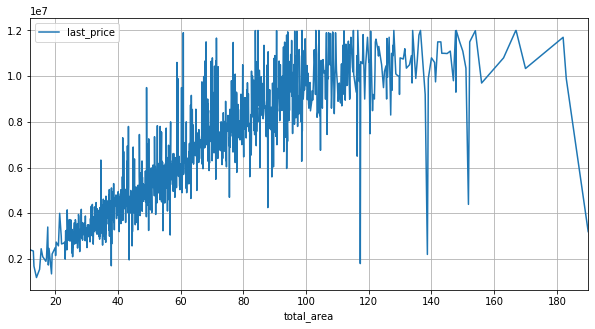

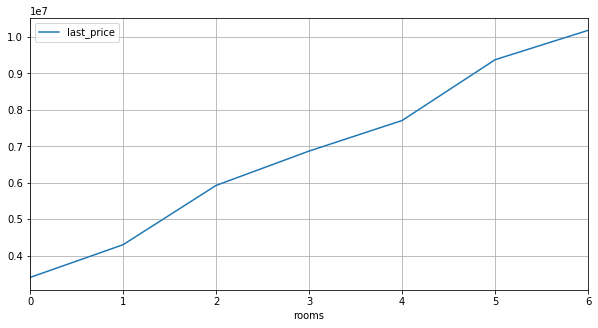

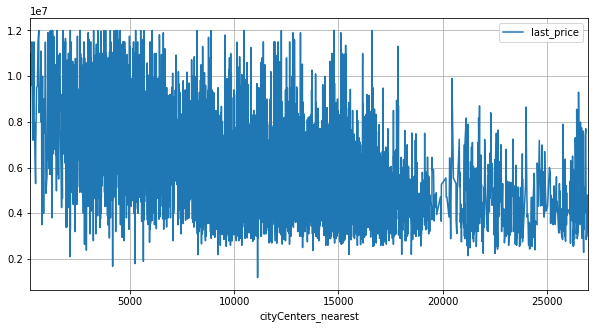

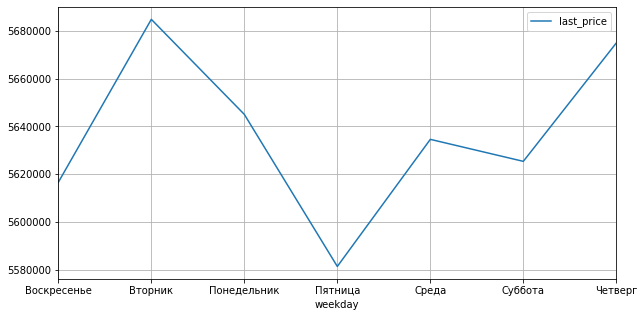

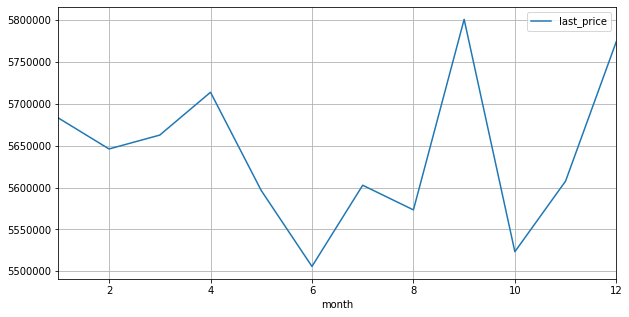

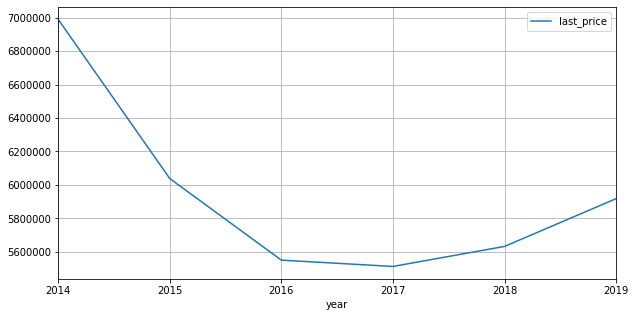

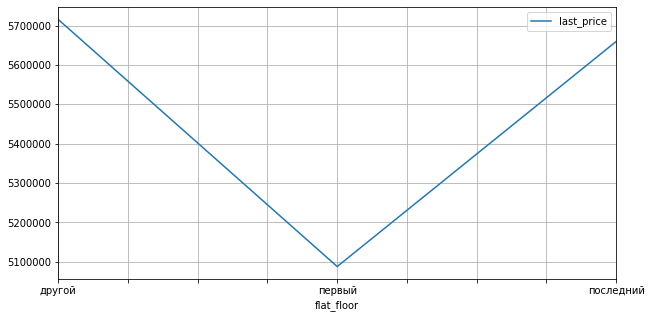

In [11]:
(filtered_data
         .pivot_table(index='total_area', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 
(filtered_data
         .pivot_table(index='rooms', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 
(filtered_data
         .pivot_table(index='cityCenters_nearest', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 
(filtered_data
         .pivot_table(index='weekday', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

(filtered_data
         .pivot_table(index='month', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

(filtered_data
         .pivot_table(index='year', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

(filtered_data
         .pivot_table(index='flat_floor', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 


### Вывод 

Какие факторы больше всего влияют на стоимость квартиры?
* зависит ли цена от площади квартиры? Безусловно. Чем больше площадь, тем выше стоимость. График направлен по возрастающей, хотя и наблюдаются некоторые аномально выпадающие значения.
* зависит ли цена от числа комнат? Конечно. Чем больше комнат, тем больше площадь. Чем больше площадь, тем выше стоимость.
* зависит ли цена от удалённости от центра? Зависит. В целом график идёт на понижение (с удалённостью от центра стоимость квартир снижается). Однако наблюдается множество выпадающих значений, это связано с тем, что на цену одновременно влияют множество факторов. И удалённость от центра в данном случае не главный фактор, влияющий на стоимость. 
* зависит ли цена от этажа, на котором расположена квартира? Судя по графику, цены на квартиры на первых этажах ниже, чем на последних и других.
* зависит ли цена от дня недели, в который было размещено объявление? Пики понижения цен приходятся на воскресенье и пятницу. Пики повышения - на вторник и четверг.
* зависит ли цена от месяца, в который было размещено объявление? Пики повышения цен на квартиры приходятся на апрель, сентябрь и декабрь. Пики понижения цен приходятся на летние месяцы (в особенности июнь и август) и октябрь.
* зависит ли цена от года, в который было размещено объявление? Судя по графику, цены на жилье резко снижались с 2014 по 2016 год, плавно снижались с 2016 по 2017. С 2017 отмечается рост цен на жильё.

### Расчёт средней цены квадратного метра в 10 населённых пунктов с наибольшим числом объявлений. Определение населённых пунктов с самой высокой и низкой стоимостью жилья.

In [12]:
top10_villages = (data
        .pivot_table(index = 'locality_name', values='price_perm2', aggfunc=['count','min','max','mean'])
        .sort_values(by=('count','price_perm2'), ascending=False)
        .iloc[:10,:])
print(top10_villages)

                        count           min           max           mean
                  price_perm2   price_perm2   price_perm2    price_perm2
locality_name                                                           
Санкт-Петербург         15721    111.834862  1.907500e+06  114849.008794
посёлок Мурино            522  50000.000000  1.385802e+05   85752.189195
посёлок Шушары            440  47700.416089  1.478261e+05   78677.364217
Всеволожск                398  31400.000000  6.404224e+05   68654.473986
Пушкин                    369  59836.065574  2.565217e+05  103125.819291
Колпино                   338  47957.371226  1.250000e+05   75424.579098
посёлок Парголово         327  39205.955335  1.385224e+05   90175.913458
Гатчина                   307  10507.246377  1.463158e+05   68746.146763
деревня Кудрово           299  54160.346696  1.428571e+05   92473.547576
Выборг                    237  18750.000000  1.074731e+05   58141.909153


###  Вывод

Определили 10 населённых пунктов с наибольшим числом объявлений. Средняя цена квадратного метра в этих населённых пунктах варьируется от 58 141 (Выборг) до 114 849 рублей (Санкт-Петербург).

### Изучение информации о расстоянии до центра. Подсчёт средней цены для каждого километра. Построение графика зависимости цены от удалённости от центра.

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
5     NaN
6    19.0
7    12.0
8     NaN
9    15.0
Name: cityCenters_nearest_bykm, dtype: float64


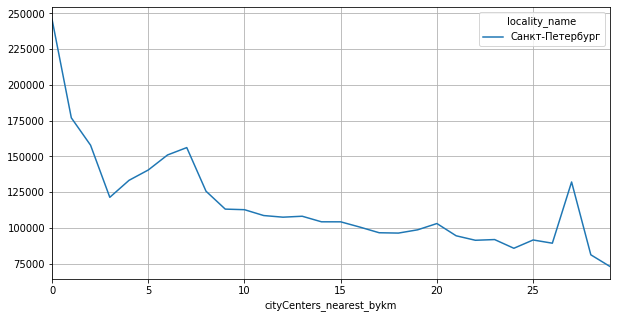

In [13]:
data['cityCenters_nearest_bykm'] =round(data['cityCenters_nearest']/1000)
print(data['cityCenters_nearest_bykm'].head(10))
centre_spb = (data
        .query('locality_name == "Санкт-Петербург"')  
        .pivot_table(index = 'cityCenters_nearest_bykm', columns='locality_name', values='price_perm2')
        .sort_values(by=['cityCenters_nearest_bykm'])
        .plot(grid=True, figsize=(10, 5)))

### Вывод 

Построили график зависимости цены от удалённости от центра. Стоимость квартир стабильно снижается примерно до удаленности 4 км от центра. На этом уровне график сильно меняется.

### Анализ и изучение параметров квартир, расположенных в центре. Выделение факторов, которые влияют на стоимость квартир в центре.

count    561.000000
mean      73.222745
std       25.628842
min       12.000000
25%       54.700000
50%       71.000000
75%       88.600000
max      182.000000
Name: total_area, dtype: float64


count    5.610000e+02
mean     7.883784e+06
std      2.216117e+06
min      2.100000e+06
25%      6.200000e+06
50%      7.990000e+06
75%      9.500000e+06
max      1.200000e+07
Name: last_price, dtype: float64


count    561.000000
mean       2.622103
std        1.047008
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        6.000000
Name: rooms, dtype: float64


count    561.000000
mean       2.969234
std        0.347297
min        2.500000
25%        2.650000
50%        2.900000
75%        3.200000
max        4.000000
Name: ceiling_height, dtype: float64


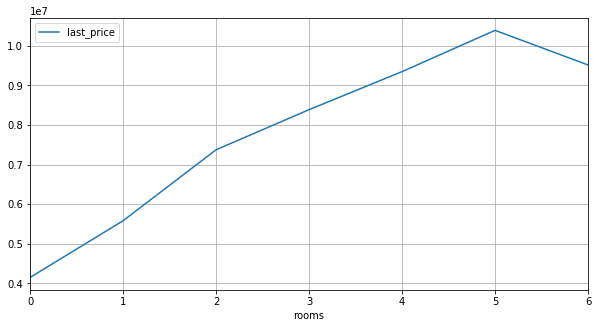

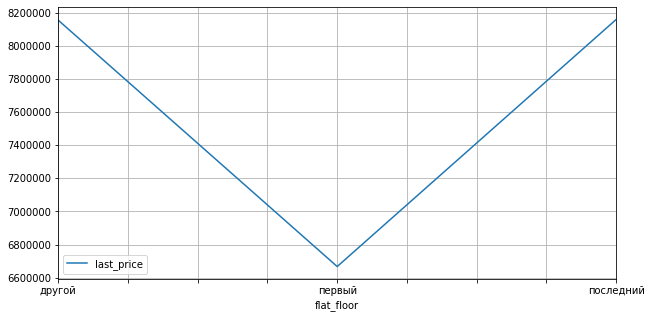

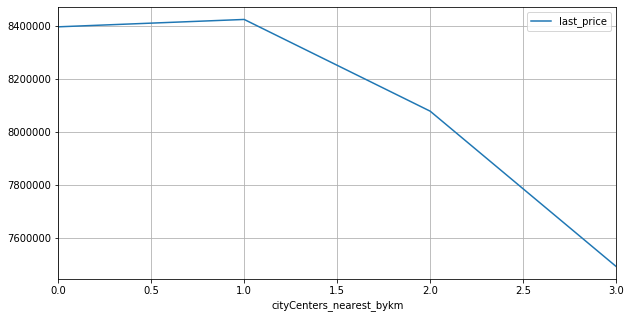

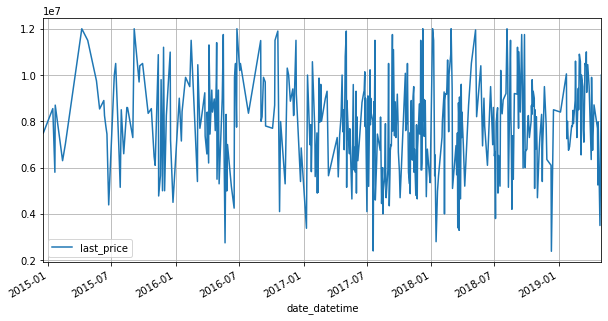

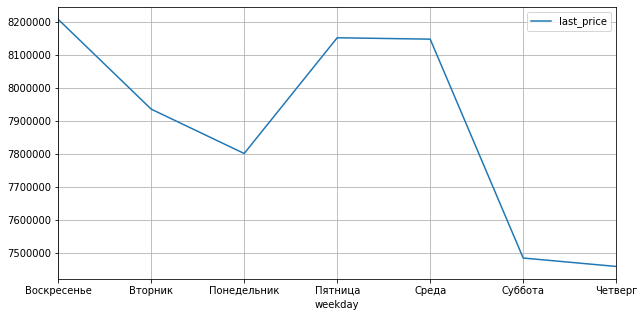

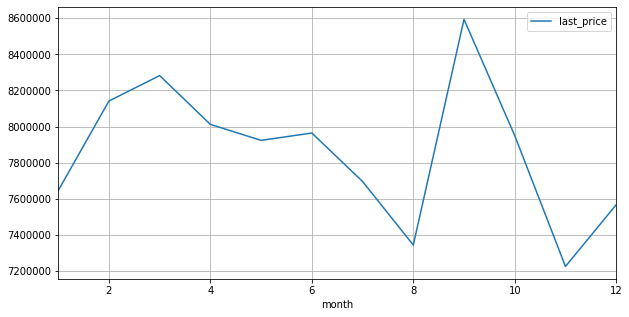

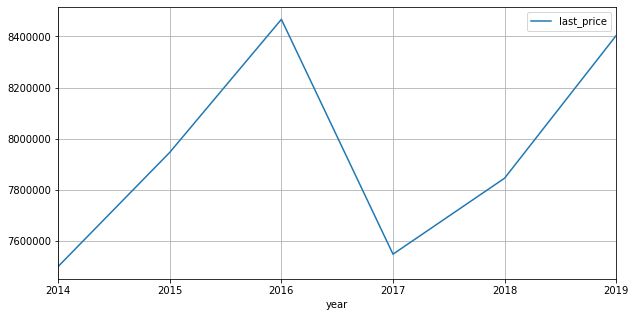

In [14]:
filtered_data_spb = data.query('total_area <= 200 and last_price <= 12000000 and rooms <= 6 and locality_name == "Санкт-Петербург" and cityCenters_nearest_bykm < 4')

print ('============================================================')

import plotly.express as px
print(filtered_data_spb['total_area'].describe())
fig = px.histogram(filtered_data_spb, x = 'total_area', marginal = 'box', title = 'Распределение '+ 'total_area')
fig.show()
print ('==============================')
print(filtered_data_spb['last_price'].describe())
fig = px.histogram(filtered_data_spb, x = 'last_price', marginal = 'box', title = 'Распределение '+ 'last_price')
fig.show()
print ('==============================')
print(filtered_data_spb['rooms'].describe())
fig = px.histogram(filtered_data_spb, x = 'rooms', marginal = 'box', title = 'Распределение '+ 'rooms')
fig.show()
print ('==============================')
print(filtered_data_spb['ceiling_height'].describe())
fig = px.histogram(filtered_data_spb, x = 'ceiling_height', marginal = 'box', title = 'Распределение '+ 'ceiling_height')
fig.show()

print ('============================================================')
(filtered_data_spb
         .pivot_table(index='rooms', values='last_price')
         .plot(grid=True, figsize=(10, 5))
);

(filtered_data_spb
         .pivot_table(index='flat_floor', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

(filtered_data_spb
         .pivot_table(index='cityCenters_nearest_bykm', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

print ('============================================================')

(filtered_data_spb
         .pivot_table(index='date_datetime', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

(filtered_data_spb
         .pivot_table(index='weekday', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

(filtered_data_spb
         .pivot_table(index='month', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

(filtered_data_spb
         .pivot_table(index='year', values='last_price')
         .plot(grid=True, figsize=(10, 5))
); 

### Вывод 

* Изучение площади: нижний «ус» упирается в 12 - минимальное значение. Верхний заканчивается около 133. Это ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом (значения представлены точками). Медиана не стремится к хвосту высоких значений. В нашем случае стандартное отклонение довольно велико, в наборе данных имеются выбросы. Среднее значение (73) и медиана (71) практически совпадают.
* Изучение цен: нижний «ус» упирается в 2,1 m - минимальное значение. Верхний заканчивается около 12 m. Это ориентировочная граница нормального размаха. Выбросов нет. Среднее значение (7,8 m) и медиана (7,9 m) совпадают. Стандартное отклонение невысокое, данные однородны.
* Изучение числа комнат: минимальное значение - 1 комната, верхняя граница - 4 комнаты. Это ориентировочная граница нормального размаха. Всё, что меньше 1 комнаты и больше 4 комнат, считается выбросом. Среднее значение и медиана совпадают. В центре города преобладают в основном 2- и 3-комнатные квартиры.
* Изучение высоты потолков: в начале проекта мы отсекли подозрительные значения, а именно высоту потолков ниже 2 метров и выше 4. Исходя из текущего графика нормальным распределением считается высота от 2,5 м до 4. Выбросов нет. Медиана и среднее значение совпадает. Стандартное отклонение имеет низкое значение, что указывает на однородность выборки.
* зависит ли цена от числа комнат? Зависит. Чем больше комнат, тем больше площадь. Чем больше площадь, тем выше стоимость.
* зависит ли цена от этажа, на котором расположена квартира? Судя по графику, цены на квартиры на первых этажах ниже, чем на последних и других.
* зависит ли цена от удалённости от центра? Да, зависит. График идёт на понижение: с удалённостью от центра стоимость квартир снижается. 
* зависит ли цена от дня недели, в который было размещено объявление? Пики понижения цен приходятся на субботу, четверг и понедельник. Пики повышения - воскресенье, пятница, среда.
* зависит ли цена от месяца, в который было размещено объявление? Пики повышения цен на квартиры приходятся на март, сентябрь и незначительно декабрь. Пики понижения цен приходятся на январь, август и ноябрь.
* зависит ли цена от года, в который было размещено объявление? Отмечены 2 пика повышения цен и 1 пика понижения. С 2014 по 2016 год резкий рост цен, затем резкое понижение в 2017. С 2017 отмечается стабильный рост цен на жильё.
По некоторым параметрам выводы отличаются от общих выводов по всему городу.

## Шаг 5. Общий вывод

* Средняя площадь квартир в центре города Санкт-Петербург (73) выше, чем в Санкт-Петербурге и соседних населённых пунктах (60,3).
* Средняя стоимость квартир в центре города Санкт-Петербург (7,8 m) выше, чем в Санкт-Петербурге и соседних населённых пунктах (6,5 m). Отличается также минимальная стоимость: в центре города минимальная стоимость квартиры составляет 2,1 m, в соседних населённых пунктах - 12,2 k. 
* В центре города преобладают в основном 2- и 3-комнатные квартиры. В районах города Санкт-Петербурге и соседних населённых пунктах чаще всего можно встретить объявления о продаже от 0 (студия, свободная планировка) до 6 комнат.
* В квартирах расположенных в центре города потолки выше. В квартирах расположенных в центре города чаще всего встречались данные о высоте потолков от 2,5 м до 4 м; в районах города Санкт-Петербурге и соседних населённых пунктах - 2,4 м до 2,86 м.
* Прямая зависимость стоимости от числа комнат показана как для центра города, так и для районов и соседних населённых пунктов.
* Цены на квартиры на первых этажах ниже, чем на последних и других как в центре города, так и в районах и соседних населённых пунктах.
* С удалённостью от центра стоимость квартир снижается. 
* В зависимости от дня недели, в который было размещено объявление о продаже, пики роста цен отмечались в воскресенье, пятницу, и среду по данным по центру города и во вторник и четверг по данным районов города Санкт-Петербурге и соседних населённых пунктов.
* В зависимости от месяца, в который было размещено объявление о продаже, пики роста цен отмечались в начале весны, сентябре и декабре как для центра города, так и для районов и соседних населённых пунктов.
* С 2014 по 2016 год происходил резкий рост, затем резкое понижение в 2017 цен на квартиры в центре города. Цены же на жилье в районах города Санкт-Петербург и соседних населённых пунктов, напротив, резко снижались с 2014 по 2016 год и плавно снижались с 2016 по 2017. С 2017 отмечается стабильный рост цен на жильё, как в центре, так и в районах.